# MEANtools (Metabolite ANticipation tools)

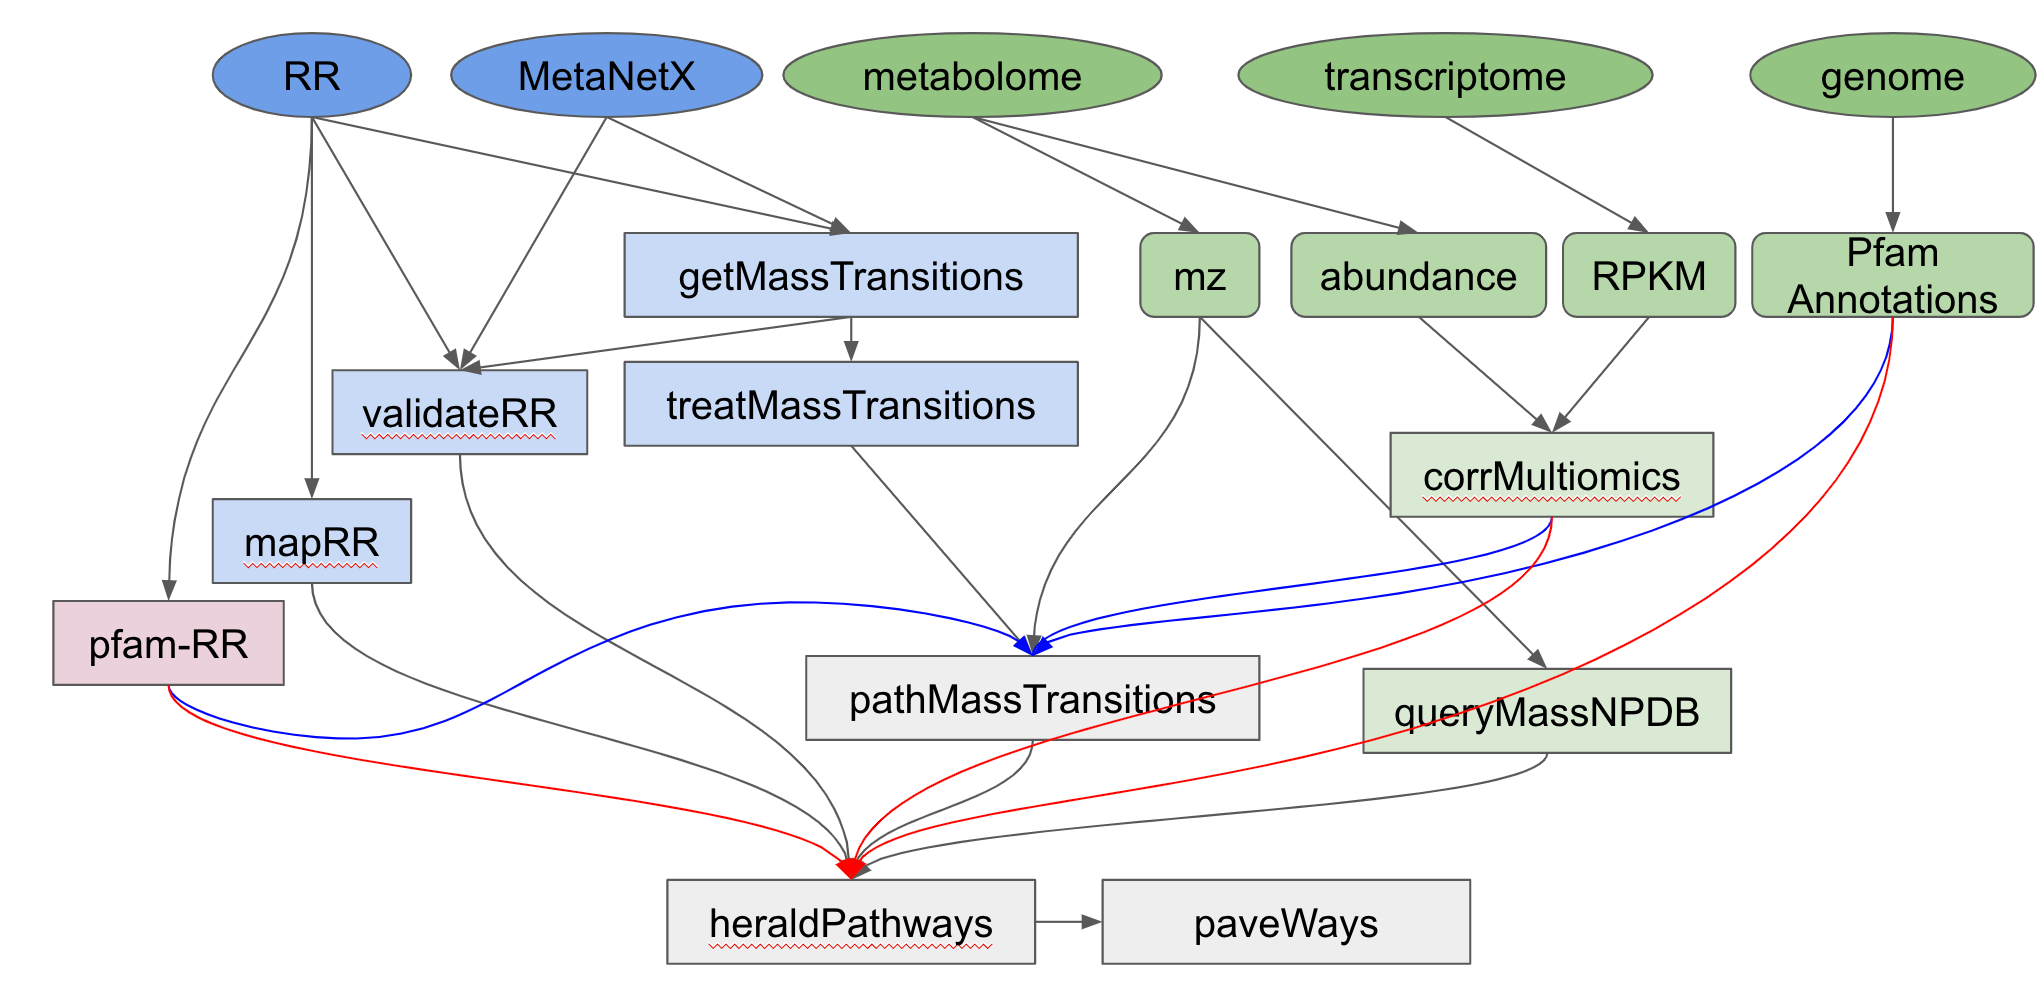

In [4]:
from IPython import display
display.Image("workflow.png")

### Arrows:
Arrows in this workflow show where the input of which script comes from.
Grey arrows show the simplest workflow: only using metabolome information.
Red and blue arrows show the additional steps when using transcriptome data as well. Introducing transcriptomic data acts as a filter: reactions without associated correlated transcripts are filtered out. Because of this, when using the blue arrows (recommended), the red arrows are not necessary.

### Squares:
Blue-colored squares are the DATABASE PREPARATION phase. These scripts parse the RetroRules database to extract the data pertinent to MEANtools. These steps only need to be performed once: upon downloading the RetroRules database.
Green-colored squares are the OMICS DATA PREPARATION phase.
Red-colored square is a list annotating the data from the RetroRules database and its PFAM predictions. This can be downloaded from #TODO.
Grey-colored squares are the PREDICTION phase.

In [22]:
%run test_db/format_databases.py -h

## Step 1

### format_databases.py

1. This script parses the RetroRules and MetaNetX database to generate a CSV with reaction_ids and their associated mass_transitions
2. This script rounds and analyses the mass_transitions generated in previous step to make it compatible with the mass transitions that will later be identified by rdkit during the virtual molecule generation process. This script also generates some plots showing the transition degeneracy (answering questions such as how many reactions can be attributed to a specific mass_transition number).
3. This script validates the SMILES in RetroRules reactions with that of the metabolites in MetaNetX. This is because some SMILES have small differences across the two databases. This script basically filters out these rules, leaving only those in which the molecular structures involved are identical as those described by MetaNetX.
4. This script maps the relationships among rules in RR. Because the molecular structures in RR rules are all described in different diameters (substructures), many of these substructures are identical across several rules, or are substructures of more complex structures in other rules. This script identifies and output these relationship to optimize the speed at which rules are tested with the metabolome data.

*For example*, this script will identify that a rule involving the substructure C-N-C does not need to be tested for a specific molecule if a rule involving the substructure C-N was already tested and was not found in the molecule.

**Base rules**: are the reaction rules that describe substructures that cannot be further decomposed in smaller substructures that are also in RetroRules. Base rules represent step number one in testing the metabolome data.

**all small rules**: are the reaction rules described at their smallest diameter, as found in RR.


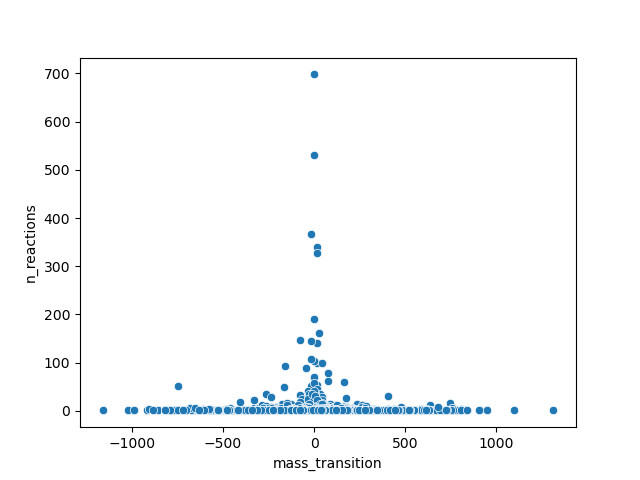

In [1]:
from IPython import display
display.Image("test_db/format_database/transitions_degeneracy.png")

In [2]:
%%bash
ls -la test_db/format_database/

total 1711560
drwxr-xr-x  12 singh018  staff        384 Apr 23 14:08 .
drwxr-xr-x   9 singh018  staff        288 Mar 12 17:53 ..
-rw-r--r--@  1 singh018  staff       6148 Apr 23 14:08 .DS_Store
-rw-r--r--@  1 singh018  staff     799529 Jun 21  2022 MassTransitions.csv
-rw-r--r--@  1 singh018  staff   45450223 Jun 21  2022 ValidateRulesWithOrigins.csv
-rw-r--r--@  1 singh018  staff  121499065 Jun 21  2022 all_small_rules.csv
-rw-r--r--@  1 singh018  staff  118780391 Jun 21  2022 base_rules.csv
-rw-r--r--@  1 singh018  staff  588932959 Jun 21  2022 chem_prop.mm_treated.tsv
-rw-r--r--@  1 singh018  staff        299 Jun 21  2022 log.txt
-rw-r--r--@  1 singh018  staff     789430 Jun 21  2022 mass_transitions.rounded.csv
-rw-r--r--@  1 singh018  staff      16370 Jun 21  2022 mass_transitions_counts.csv
-rw-r--r--@  1 singh018  staff      23499 Jun 21  2022 transitions_degeneracy.png


In [5]:
%%bash
#head Jeon_tomato/test_data/test.bac.abundance.csv
#head Jeon_tomato/test_data/test.bac.rnaseq.rpkm.csv
#head Jeon_tomato/test_data/test.bac.metabolome.csv

metabolite,mz
M1004T1618,1004.497409
M1006T1618,1005.500795
M1046T1711,1045.5483359999998
M1049T785,1048.530304
M1050T786,1049.533929
M1051T1182,1050.5464869999998
M1052T1931,1051.615978
M1053T1931,1052.619311
M1116T973,1115.563002


In [7]:
%run queryMassNPDB_mod.py -h

usage: queryStructures [-h] -add ADDUCTS_FILE -ms MASS_SIGNATURES_FILE -db
                       {lotus,custom} -dbp STRUCTURES_DB_PATH -dtn
                       STRUCTURES_DB_TABLENAME [-t TAXONOMY] -dn
                       SQLITE_DB_NAME -tn SQLITE_TABLE_NAME -c CHUNK_SIZE -p
                       PPM [-csv] [-o OUTPUT_FOLDER] [-v VERBOSE]

Integrate LOTUS database and extract structures based on your mass signatures!

optional arguments:
  -h, --help            show this help message and exit
  -add ADDUCTS_FILE, --adducts_file ADDUCTS_FILE
                        ESI-MS_adducts.csv
  -ms MASS_SIGNATURES_FILE, --mass_signatures_file MASS_SIGNATURES_FILE
                        Mass signatures two column file: {id,mz}
  -db {lotus,custom}, --structures_db {lotus,custom}
                        Use either LOTUS db file or a custom db file!
  -dbp STRUCTURES_DB_PATH, --structures_db_path STRUCTURES_DB_PATH
                        Path of the database file!
  -dtn STRUCTURES_DB_TA

In [8]:
%%bash
cat docs/ESI-MS-adducts.csv

Ion_name,Ion_mode,Ion_mass,Charge,Mult,Mass
M+3H ,positive,M/3 + 1.007276 ,3,0.333,1.007276
M+2H+Na ,positive,M/3 + 8.334590 ,3,0.333,8.33459
M+H+2Na ,positive,M/3 + 15.7661904 ,3,0.333,15.76619
M+3Na ,positive,M/3 + 22.989218 ,3,0.333,22.989218
M+2H ,positive,M/2 + 1.007276 ,2,0.5,1.007276
M+H+NH4 ,positive,M/2 + 9.520550 ,2,0.5,9.52055
M+H+Na ,positive,M/2 + 11.998247 ,2,0.5,11.998247
M+H+K ,positive,M/2 + 19.985217 ,2,0.5,19.985217
M+ACN+2H,positive,M/2 + 21.520550 ,2,0.5,21.52055
M+2Na ,positive,M/2 + 22.989218 ,2,0.5,22.989218
M+2ACN+2H,positive,M/2 + 42.033823 ,2,0.5,42.033823
M+3ACN+2H,positive,M/2 + 62.547097 ,2,0.5,62.547097
M+H ,positive,M + 1.007276 ,1,1,1.007276
M+NH4 ,positive,M + 18.033823 ,1,1,18.033823
M+Na ,positive,M + 22.989218 ,1,1,22.989218
M+CH3OH+H ,positive,M + 33.033489 ,1,1,33.033489
M+K ,positive,M + 38.963158 ,1,1,38.963158
M+ACN+H ,positive,M + 42.033823 ,1,1,42.033823
M+2Na-H ,positive,M + 44.971160 ,1,1,44.97116
M+IsoProp+H,positive,M + 61.06534,1,1,61.06

In [9]:
%run queryMassNPDB_mod.py -add docs/ESI-MS-adducts.csv -ms Jeon_tomato/test_data/test.bac.metabolome.csv -db lotus -dbp demo.sqlite -dtn Jeon_dummy_falcarindiol -t Solanum -dn test.sqlite -tn test_metabolites -c 20 -p 20 -v True

Step 1: Adducts file is loaded!
Step 2: Metabolome file is loaded!


Processing m/z chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 53.31chunk/s]


## STEP 2

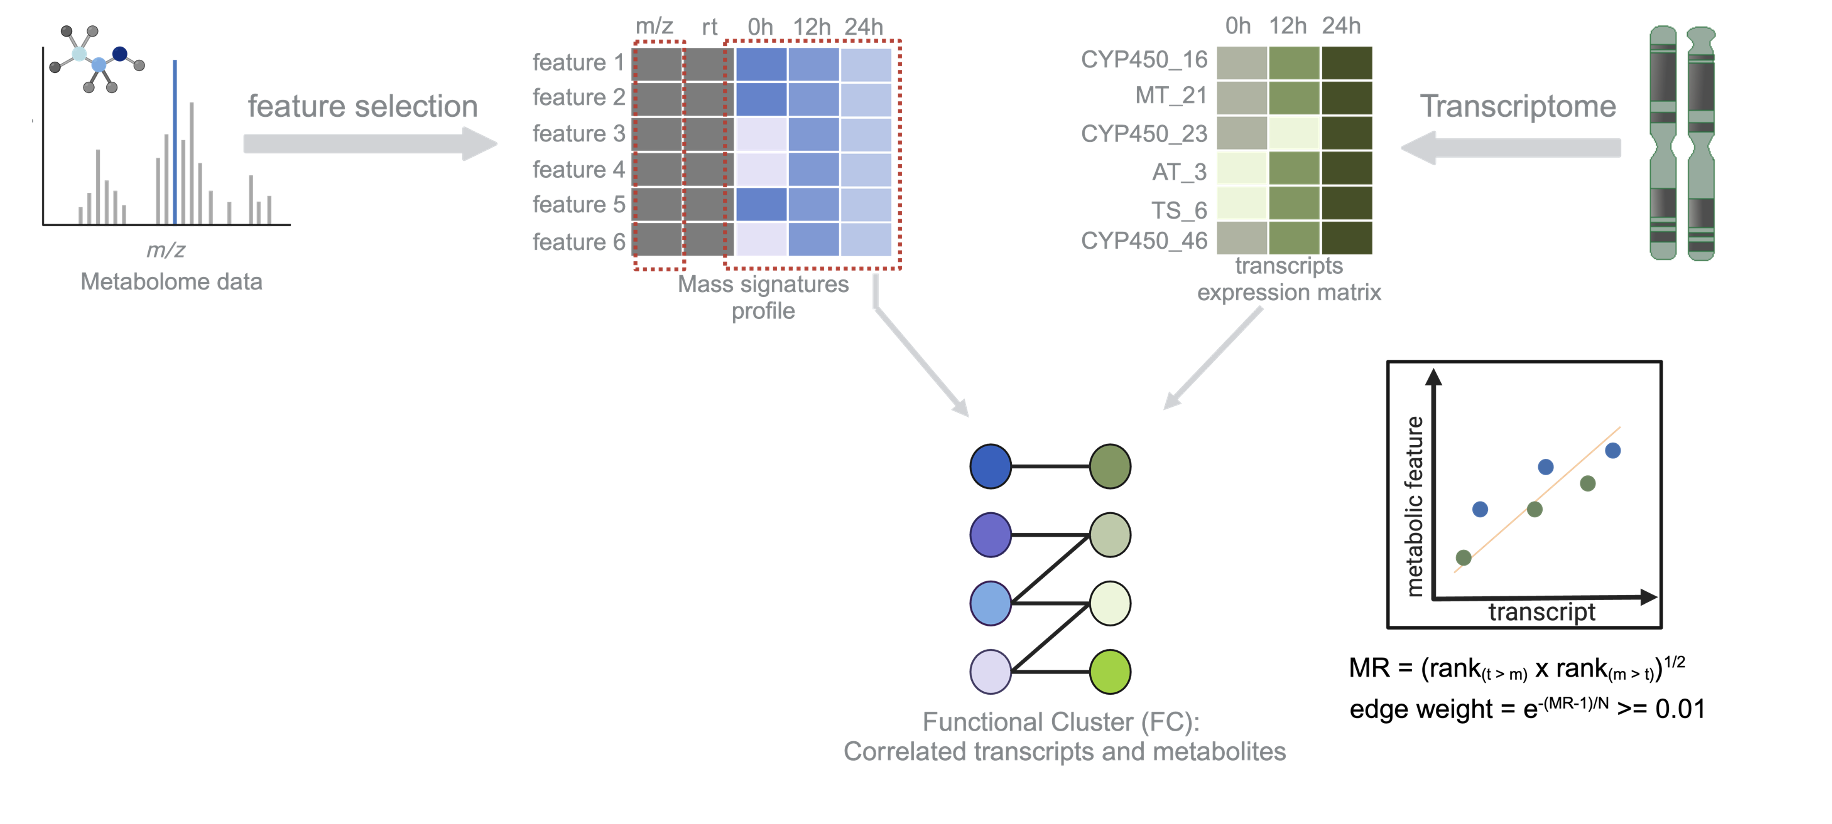

In [10]:
from IPython import display
display.Image("correlation.png")

In [11]:
%run corrMultiomics_mod.py -h

usage: corrMultiomics_mod.py [-h] -ft FEATURE_TABLE [-qm QUANTITATION_MATRIX]
                             [-m {spearman,pearson,pearsonlog}] [-mr] [-cl]
                             [-mad] [-r] [-c CORRELATION_CUTOFF]
                             [-w EDGE_WEIGHT_CUTOFF] [-d DECAY_RATE]
                             [-mdr MULTI_DECAY_RATES [MULTI_DECAY_RATES ...]]
                             [-a ANNOTATION] [-p] [-t THREADS] -dn
                             SQLITE_DB_NAME -tn SQLITE_TABLE_NAME [-v]

optional arguments:
  -h, --help            show this help message and exit
  -ft FEATURE_TABLE, --feature_table FEATURE_TABLE
                        Metabolomics-based feature table.
  -qm QUANTITATION_MATRIX, --quantitation_matrix QUANTITATION_MATRIX
                        Normalized expression table from the RNAseq data.
  -m {spearman,pearson,pearsonlog}, --method {spearman,pearson,pearsonlog}
                        Default is the pearson correlation method; pearsonlog
              

In [1]:
%run corrMultiomics_mod.py -ft Jeon_tomato/test_data/test.bac.abundance.csv -qm Jeon_tomato/test_data/test.bac.rnaseq.rpkm.csv -mr -cl -mad -r -c 0.1 -w 0.01 -mdr 5 10 25 50 -t 4 -dn test.sqlite -tn bacterial

Getting mutual ranks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961191/961191 [00:01<00:00, 596779.95it/s]


Estimating edge weights using exponetial decay...
Writing mutual ranks with decay rate of 5 to the database...
Generating modules with the decay rate of 5 using ClusterOne...




Loaded graph with 1387 nodes and 13186 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 569 complexes




Estimating edge weights using exponetial decay...
Writing mutual ranks with decay rate of 10 to the database...
Generating modules with the decay rate of 10 using ClusterOne...




Loaded graph with 1387 nodes and 27811 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 460 complexes




Estimating edge weights using exponetial decay...
Writing mutual ranks with decay rate of 25 to the database...
Generating modules with the decay rate of 25 using ClusterOne...




Loaded graph with 1387 nodes and 70925 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 260 complexes




Estimating edge weights using exponetial decay...
Writing mutual ranks with decay rate of 50 to the database...
Generating modules with the decay rate of 50 using ClusterOne...




Loaded graph with 1387 nodes and 141054 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 140 complexes


In [3]:
%run merge_clusters.py -h

usage: merge_clusters.py [-h] -ft FEATURE_TABLE -qm QUANTITATION_MATRIX
                         [-l TARGETED_LIST] [-a] [-m] [-f ANNOTATION_FILE]
                         [-mc] [-mm {fingerprinting,overlap}] [-dr DECAY_RATE]
                         [-e] [-es {coex,specnet}] [-o OUTFILE] -dn
                         SQLITE_DB_NAME

optional arguments:
  -h, --help            show this help message and exit
  -ft FEATURE_TABLE, --feature_table FEATURE_TABLE
                        Metabolomics-based feature table!
  -qm QUANTITATION_MATRIX, --quantitation_matrix QUANTITATION_MATRIX
                        Normalized expression table from the RNAseq data!
  -l TARGETED_LIST, --targeted_list TARGETED_LIST
                        Target list of genes and metabolites in a csv file.
                        <ID><metabolites><genes>
  -a, --annotation      Flag for annotation. Default is False
  -m, --heatmap         Flag for generating heatmaps for each FCs. Default is
                      

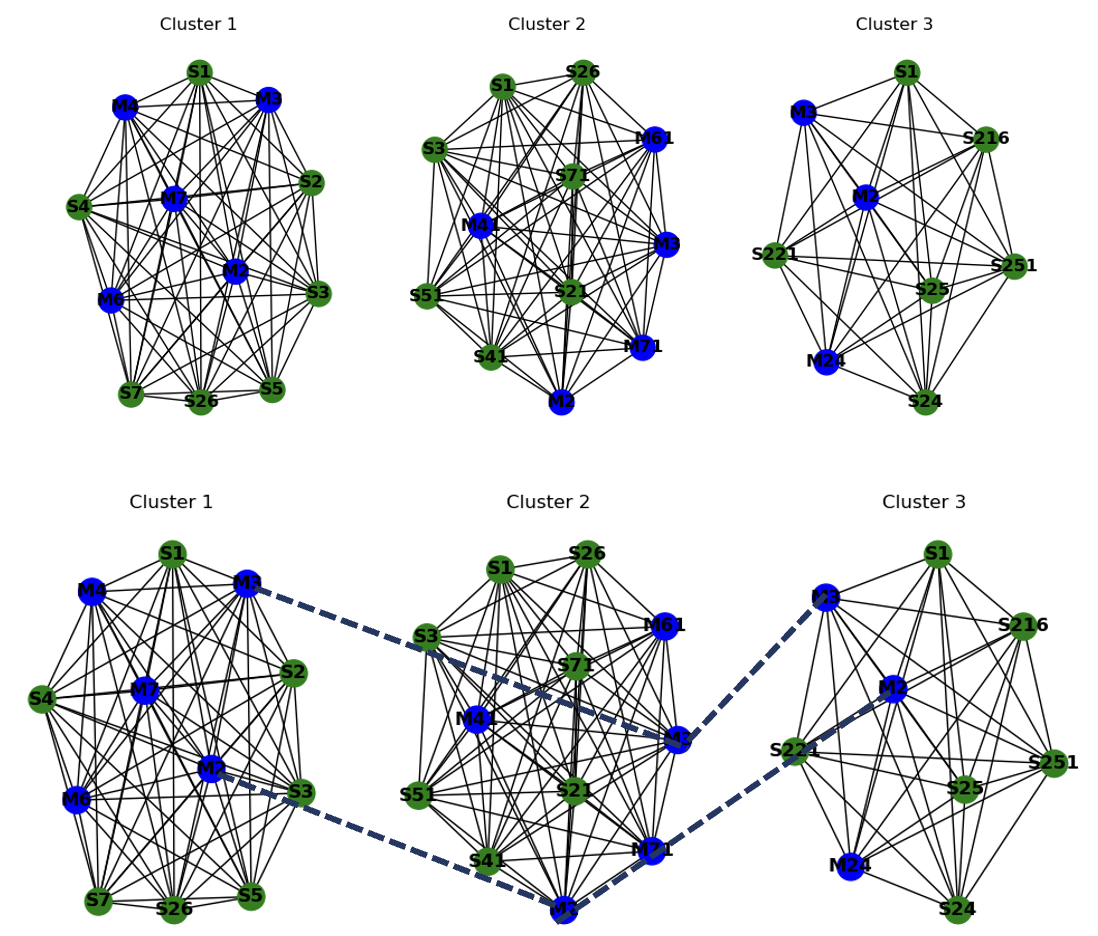

In [2]:
from IPython import display
display.Image("overlap.png")

In [4]:
%run merge_clusters.py -ft Jeon_tomato/test_data/test.bac.abundance.csv -qm Jeon_tomato/test_data/test.bac.rnaseq.rpkm.csv -mc -mm overlap -dr 25 -dn test.sqlite

Checking overlap between FCs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 13249.09it/s]


## STEP 3


### pathMassTransitions.py
This script integrates the metabolome and transcriptome data with the RR and MetaNetX data. In short, this script filters the mass transitions associated with RR reactions according to the mass signatures found in the metabolome. In this manner, if the metabolome has no metabolites with a mass of a 1000, then reactions involving masses of a 1000 are filtered out.

Important optional arguments:

**--ghost**: Adds "ghost" mass signatures; these are metabolites that cannot be measured in the metabolome. Each ghost mass signature is linked to at least two other metabolites that can be measured.

**--corr_cutoff** and **--corr_p_cutoff** to filter the correlation input through custom thresholds.

**--pfam_RR_annotation_dataset** to filter the associations between pfams and RR reactions (which are often predictions).

In [5]:
%run pathMassTransitions_mod.py -h

usage: pathMassTransitions_mod.py [-h] -c MERGED_CLUSTERS_FILE -t
                                  MASS_TRANSITIONS_FILE [-g] -dn
                                  SQLITE_DB_NAME -tn SQLITE_TABLE_NAME -ct
                                  SQLITE_CORR_TABLENAME -mt
                                  SQLITE_METABOLITE_TABLENAME -p
                                  PFAM_RR_ANNOTATION_FILE -a
                                  GENE_ANNOTATION_FILE
                                  [-s {strict,medium,loose}] [-cc CORR_CUTOFF]
                                  [-cpc CORR_P_CUTOFF] [-o OUTPUT_FILE]
                                  [--verbose]

optional arguments:
  -h, --help            show this help message and exit
  -c MERGED_CLUSTERS_FILE, --merged_clusters_file MERGED_CLUSTERS_FILE
                        Two-column csv with header. One mass signature per
                        line. Format: ms_id,mz,mm
  -t MASS_TRANSITIONS_FILE, --mass_transitions_file MASS_TRANSITIONS_FILE
         

In [6]:
%run pathMassTransitions_mod.py -c Jeon_tomato/test_data/test_merged_cluster_filtered.csv -t test_db/format_database/MassTransitions.csv -dn test.sqlite -tn transitions_test_falca -ct bacterial -mt test_metabolites -p pfam_RR_annotation_file.csv -a Jeon_tomato/Bacterial/bacterial.tomato.pfams.sol.csv -s loose -cc 0.1 -cpc 1 -v

Loading data...
Loading gene annotations...
Loading pfam-RR annotations...
Integrating annotations, and RR...
Integrating correlations...
Duplicate cleanup...
Identifying transitions...
Solving transitions...
Writing...


### heraldPathways.py

This is script is the heart of the prediction process.

This script integrates all data to produce pathway predictions. Here, all input is integreated, and all results are output as CSV tables, EXCEL, SVGs images. However, these results relate to the entire -omics data used. It is advised to use **paveWays.py** to further filter out the results and generate visualizations or filtered tables of predicted pathways that are easier to interpret.

The following optional argument is VERY important:

**--iterations**
The script will test structures in separate iterations. If setting this parameter to 1, then only the input structure (reaction substrates) will be tested, generating an additional set of substructures (virtual molecules, reaction products) and therefore the longest pathway that (often) will be predicted will be one-reaction-long. If using iterations=2, then the virtual molecules predicted from the first iterations, will also be tested, generating a third set of molecules (virtual molecules, reaction products of the second set of molecules). Therefore, the larger this parameter, the longer the pathways that can be predicted, however, each new iteration will (likely) result in a larger set of molecules than the previous one, so handle with care according to computing, memory and time limitation.

**TIP**: Use all structures of an expected pathway as input and select iterations=1. The script will only test one reaction per structure, but if the script manages to recover/predict the correct reactions, it will result in a predicted pathway longer than one-reaction-long despite only using iterations=1 (because all input structures should be one-reaction-away from at least one other input structure).

In [13]:
%run heraldPathways_mod.py -h

In [ ]:
%run heraldPathways_mod.py -c Jeon_tomato/test_data/test_merged_cluster_filtered.csv -r test_db/format_database/ValidateRulesWithOrigins.csv -m test_db/format_database/base_rules.csv -p pfam_RR_annotation_file.csv -a Jeon_tomato/Bacterial/bacterial.tomato.pfams.sol.csv -s loose -i 3 -dn test.sqlite -tn test_herald -ct bacterial -mt test_metabolites -tt transitions_test_falca -v -dv -o test_herald -d pfams_dict.csv

In [8]:
%%bash
#ls test_herald
#head test_herald/summary.csv
head test_herald/reactions.csv

ms_substrate,ms_product,expected_mass_transition,predicted_mass_transition,mass_transition_difference,reaction_id,substrate_id,product_id,substrate_mnx,product_mnx,root,predicted_substrate_id,predicted_product_id,predicted_substrate_smiles,predicted_product_smiles,smarts_id,diameter,RR_substrate_smarts,RR_product_smarts,uniprot_id,uniprot_enzyme_pfams,KO,rhea_id_reaction,kegg_id_reaction,rhea_confirmation,kegg_confirmation,KO_prediction,gene,enzyme_pfams,correlation_substrate,P_substrate,correlation_product,P_product
M635T910,M651T632,15.99,16.0,0.009999999999999787,39943,5176,5017,MNXM402,MNXM2457,linoleic_acid,linoleic_acid,VM_3747695,CCCCC/C=C\C/C=C/CCCCCCCC(=O)O,CCCCC/C=C\C/C=C(\O)CCCCCCCC(=O)O,RR00034377,16,[#6:1](-[#6:2]-[#6:3]-[#6:4]-[#6:5]-[#6:6]-[#6:7])-[#6:21]-[#6:22],[#6:1](-[#6:2]-[#6:3]-[#6:4]-[#6:5]-[#6:6]-[#6:7]-[#8])-[#6:21]-[#6:22].[#8],A2A974,PF00067,,,,False,False,False,Solyc12g042480.1,PF00067,,,0.5057106448836648,0.011699952347906854
M635T910,M651T632,15.99,16.0,0.

### paveWays.py

This script creates tables and visualizations from the predicted reactions that are easier to interpret by filtering according to user input.

The mandatory input of this script is the structure predictions of heraldPathways. When using only this input, this script will generate SVGs of all structures predicted, which can be easily browsed to find interesting predicted structures and their ID

In [6]:
%run paveWays.py -h

In [9]:
%run paveWays.py -sp test_herald/structure_predictions.csv -of test_paveWays -r test_herald/reactions.csv -praf pfam_RR_annotation_file.csv -gaf Jeon_tomato/Bacterial/bacterial.tomato.pfams.sol.csv -rr loose -pam True -pup True -v

Loading structures...
Loading reactions...
Loading gene annotations...
Loading pfam-RR annotations...
Integrating annotations, and RR...
Duplicate cleanup...
Generating networks...
Processing each network...
These edges are going to be removed []
These edges are going to be removed []
These edges are going to be removed []
These edges are going to be removed []
This is cur_cycle_nodes ['meta_6', 'octadecadiene_diynoic_acid']
This is substrate: meta_6 and this is product: octadecadiene_diynoic_acid
This is current_edge_data {'genes_corr_substrate': 170, 'genes_corr_product': 90, 'genes_corr_both': 0}
This is cur_edge_support 260
This substrate meta_6 and product octadecadiene_diynoic_acid were found in the structures_attributes_df_indexed.index
This is cur_substrate_distance: 3
This is cur_product_distance: 1
This is substrate: octadecadiene_diynoic_acid and this is product: meta_6
This is current_edge_data {'genes_corr_substrate': 10, 'genes_corr_product': 14, 'genes_corr_both': 4}
Thi